# Calculations of longwave radiation

Outgoing longwave is relatively straightforward to calculate as it is a function of the sea surface temperature:

<img src = 'longwave_cartoon.jpg'>

\begin{eqnarray}
Q_{L} = \epsilon \sigma T_{SST}^{4}
\end{eqnarray}

The buoys directly measure incoming $Q_{L}$, so the net is the difference between the derived number above and the observed measurement.  The coupled model provides both up and downward longwave, so here we can directly compare the two.

In [1]:
# import necessary packages
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from datetime import datetime, timedelta

In [2]:
# Read model output and observations from ORS

In [3]:
site = 'WHOTS'
lat = 22.7667
lon = -157.8983
#site = 'NTAS'
#site = 'Stratus'

In [4]:
# load CFSv2 data; note the model provides both up- and downward Qs
data = np.loadtxt('/Users/jimp/Research/whoi/cfs/' + site + '_dlwsfc.dat')
cfs_ql_down = data[:,1]
data = np.loadtxt('/Users/jimp/Research/whoi/cfs/' + site + '_ulwsfc.dat')
cfs_ql_up = data[:,1]
data = np.loadtxt('/Users/jimp/Research/whoi/cfs/' + site + '_tmpsfc.dat')
cfs_sst = data[:,1]
mtime = pd.to_datetime([i for i in range(len(cfs_sst))], unit='h', origin = pd.Timestamp('1979-01-01 00:00:00'))

In [5]:
# load ORS obs

# WHOTS
if site == 'WHOTS':
    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots1to9_best_flux_1hr.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots1to9_best_met_1hr.mat',squeeze_me=True)
    data = fin1['Ql']
    Ql = data
    data = fin2['sst']
    sst = data
    data = fin1['mday']
    time = data

    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots10_flux_1hr.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots10_met_1hr.mat',squeeze_me=True)
    data = fin1['Ql']
    Ql = np.append ( Ql, data[82:] )
    data = fin2['sst']
    sst = np.append ( sst, data[82:])
    data = fin1['mday']
    time = np.append ( time, data[82:] )
   
    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots11_flux_1hr.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots11_met_1hr.mat',squeeze_me=True)
    data = fin1['Ql']
    Ql = np.append ( Ql, data[84:] )
    data = fin2['sst']
    sst = np.append ( sst, data[84:])
    data = fin1['mday']
    time = np.append ( time, data[84:] )

    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots12_flux_1hr.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots12_met_1hr.mat',squeeze_me=True)
    data = fin1['Ql']
    Ql = np.append ( Ql, data[60:] )
    data = fin2['sst']
    sst = np.append ( sst, data[60:])
    data = fin1['mday']
    time = np.append ( time, data[60:] )

    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots13_flux_1hr.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots13_met_1hr.mat',squeeze_me=True)
    data = fin1['Ql'] 
    Ql = np.append ( Ql, data[54:] )
    data = fin2['sst']
    sst = np.append ( sst, data[54:])
    data = fin1['mday']
    time = np.append ( time, data[54:] )
    
    time = pd.date_range('2004-08-13 04:30:00', '2017-07-31 15:30:00', freq='H')
#    time = time.apply(lambda datetime.fromordinal(int(Time)) + timedelta(days=Time%1) - timedelta(days = 366 ))

# Stratus
if site == 'Stratus':
    fin = loadmat('/Users/jimp/Desktop/whoi/obs/data/str1to10_best_flux_1hr.mat',squeeze_me=True)
    data = fin['Ql']
    Ql = data
    data = fin1['sst']
    sst = data
    data = fin['mday']
    time = data

    fin = loadmat('/Users/jimp/Desktop/whoi/obs/data/str11to14_best_flux_1hr.mat',squeeze_me=True)
    data = fin['Ql']
    Ql = np.append ( Ql, data )
    data = fin1['sst']
    sst = np.append ( sst, data )
    data = fin['mday']
    time = np.append ( time, data )
    
#    time = time.apply(lambda datetime.fromordinal(int(Time)) + timedelta(days=Time%1) - timedelta(days = 366 ))

# NTAS
if site == 'NTAS':
    Ql = np.array(fin1.variables['QL'])
    fin1 = Dataset('/disk/whoi_sub/whoi/ntas/OS_NTAS_2001-2012_D_FLTS-1hr.nc', 'r')
    data = np.array(fin1.variables['QL'])
    Ql =  data
    data = np.array(fin1.variables['TIME'])
    time = data

    fin1 = Dataset('/disk/whoi_sub/whoi/ntas/OS_NTAS_2012-2014_D_FLTS-1hr.nc', 'r')
    data = np.array(fin1.variables['QL'])
    Ql = Ql.append ( data, ignore_index = True )
    data = np.array(fin1.variables['TIME'])
    time = time.append ( data, ignore_index = True )
    
    time = pd.to_datetime(time, unit='d', origin = pd.Timestamp('1950-01-01 00:00:00'))

In [6]:
# Compute outgoing
epsilon = 0.97
sigma = 567E-10
Ql_out = epsilon * sigma * ( sst + 273.15 )**4
cfs_ql_sst = epsilon * sigma * ( cfs_sst )**4

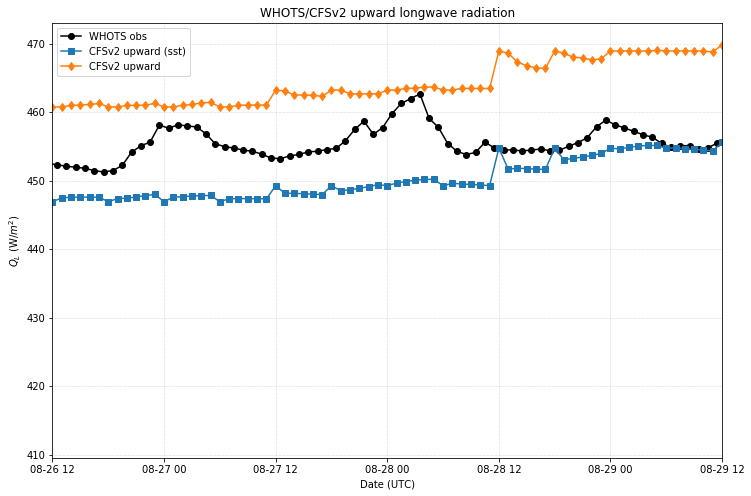

In [7]:
# Plot an arbitrary three-day period
fig, ax = plt.subplots( figsize = ( 12, 8 ) )
ax.plot(time,Ql_out,'ko-',label='WHOTS obs')
ax.plot(mtime,cfs_ql_sst,'s-',label='CFSv2 upward (sst)')
ax.plot(mtime,cfs_ql_up,'d-',label='CFSv2 upward')
ax.set_xlim([datetime(2015, 8, 26, 12), datetime(2015, 8, 29, 12)])
ax.set_title('WHOTS/CFSv2 upward longwave radiation')
ax.set_xlabel('Date (UTC)')
ax.set_ylabel('$Q_{L}$ (W/$m^2$)')
ax.legend()
ax.grid(linestyle=':', linewidth=0.5)

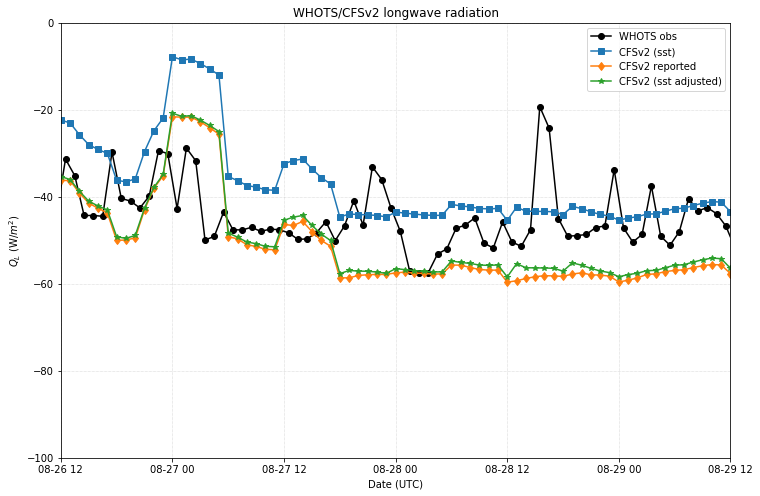

In [8]:
# Plot an arbitrary three-day period
fig, ax = plt.subplots( figsize = ( 12, 8 ) )
ax.plot(time,Ql,'ko-',label='WHOTS obs')
ax.plot(mtime,cfs_ql_down-cfs_ql_sst,'s-',label='CFSv2 (sst)')
ax.plot(mtime,cfs_ql_down-cfs_ql_up,'d-',label='CFSv2 reported')
ax.plot(mtime,cfs_ql_down-cfs_ql_sst-13,'*-',label='CFSv2 (sst adjusted)')
ax.set_xlim([datetime(2015, 8, 26, 12), datetime(2015, 8, 29, 12)])
ax.set_ylim([-100, 0])
ax.set_title('WHOTS/CFSv2 longwave radiation')
ax.set_xlabel('Date (UTC)')
ax.set_ylabel('$Q_{L}$ (W/$m^2$)')
ax.legend()
ax.grid(linestyle=':', linewidth=0.5)

In [9]:
# add model and obs to DataFrames
model_data =  pd.DataFrame({'Time':mtime, 'cfs_up': cfs_ql_up, 'cfs_down': cfs_ql_down, 
                            'cfs_sst': cfs_sst, 'cfs_ql_sst': cfs_ql_sst})
obs_data = pd.DataFrame({'Time':time, 'obs_ql': Ql, 'obs_sst': sst, 'obs_ql_sst': Ql_out})

# now combine to single DataFrame
AllData = pd.merge_asof(obs_data,model_data,on='Time', tolerance=pd.Timedelta('60 minute'))

Correlation CFS net (up-down) to observed: -0.44102218202671134
Correlation CFS SST-derived to observed SST-derived: 0.9652481231148192
Correlation CFS upward to CFS SST derived: 0.9980823861641707
Correlation CFS upward to downward: 0.3803784427189964
Correlation CFS net (up-down) to CFS SST derived: -0.05050127478996508
Correlation CFS down to observed downward: -0.28768859857837015


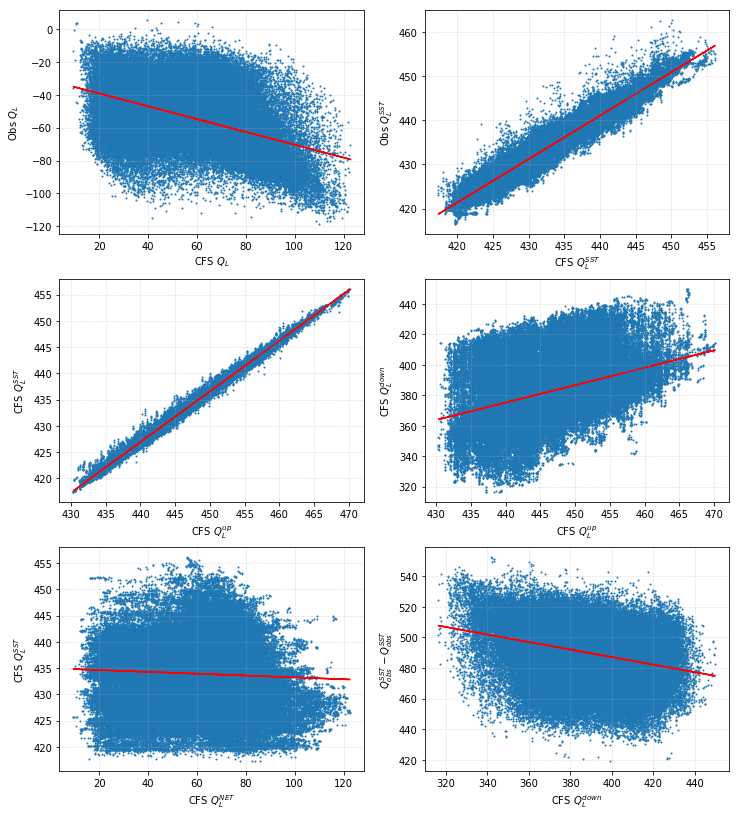

In [13]:
time = AllData['Time']
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(12,14))

#   1. Upper left figure is net longwave from model compared to obs
x = AllData['cfs_up']-AllData['cfs_down']
y = AllData['obs_ql']
ax[0,0].scatter(x,y,s=1,rasterized=True)

#   do linear regression fit (check for NaN's first)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[0,0].plot(x,A,color='red')

#   find correlation coefficient (slope of Z_x vs Z_y)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx]) 
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx]) 
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS net (up-down) to observed: ' + str(C[0]) )
#   draw 1:1 line in black
#x1, y1 = [minax,maxax],[minax,maxax]
#ax[0,0].plot(x1,y1,color='black')

ax[0,0].set_xlabel('CFS $Q_{L}$')
ax[0,0].set_ylabel('Obs $Q_{L}$')
#ax[0,0].set_title(site)
ax[0,0].grid(linestyle=':', linewidth=0.5)

#   2. Upper right figure is parameterized outgoing longwave using
#      model SST compared to the same using observed SST
x = AllData['cfs_ql_sst']
y = AllData['obs_ql_sst']
ax[0,1].scatter(x,y,s=1,rasterized=True)

#   do linear regression fit (check for NaN's first)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[0,1].plot(x,A,color='red')

#   find correlation coefficient (slope of Z_x vs Z_y)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx]) 
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx]) 
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS SST-derived to observed SST-derived: ' + str(C[0]) )
#   draw 1:1 line in black
#x1, y1 = [minax,maxax],[minax,maxax]
#ax[0,1].plot(x1,y1,color='black')

ax[0,1].set_xlabel('CFS $Q_{L}^{SST}$')
ax[0,1].set_ylabel('Obs $Q_{L}^{SST}$')
#ax[0,1].set_title(site)
ax[0,1].grid(linestyle=':', linewidth=0.5)
    
#   3. Center left figure is model upward (give) vs. upward parameterized
#   using model SST
x = AllData['cfs_up']
y = AllData['cfs_ql_sst']
ax[1,0].scatter(x,y,s=1,rasterized=True)

#   do linear regression fit (check for NaN's first)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[1,0].plot(x,A,color='red')

#   find correlation coefficient (slope of Z_x vs Z_y)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx]) 
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx]) 
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS upward to CFS SST derived: ' + str(C[0]) )
#   draw 1:1 line in black
#x1, y1 = [minax,maxax],[minax,maxax]
#ax[1,0].plot(x1,y1,color='black')

ax[1,0].set_xlabel('CFS $Q_{L}^{up}$')
ax[1,0].set_ylabel('CFS $Q_{L}^{SST}$')
#ax[1,0].set_title(site)
ax[1,0].grid(linestyle=':', linewidth=0.5)
    
#   4. Center right is model upward vs. downward longwave
x = AllData['cfs_up']
y = AllData['cfs_down']
ax[1,1].scatter(x,y,s=1,rasterized=True)

#   do linear regression fit (check for NaN's first)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[1,1].plot(x,A,color='red')

#   find correlation coefficient (slope of Z_x vs Z_y)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx]) 
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx]) 
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS upward to downward: ' + str(C[0]) )
#   draw 1:1 line in black
#x1, y1 = [minax,maxax],[minax,maxax]
#ax[1,1].plot(x1,y1,color='black')

ax[1,1].set_xlabel('CFS $Q_{L}^{up}$')
ax[1,1].set_ylabel('CFS $Q_{L}^{down}$')
#ax[1,1].set_title(site)
ax[1,1].grid(linestyle=':', linewidth=0.5)

#   5.  Lower left is model net longwave vs. model upward (parameterized)
x = AllData['cfs_up']-AllData['cfs_down']
y = AllData['cfs_ql_sst']
ax[2,0].scatter(x,y,s=1,rasterized=True)

#   do linear regression fit (check for NaN's first)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[2,0].plot(x,A,color='red')

#   find correlation coefficient (slope of Z_x vs Z_y)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx]) 
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx]) 
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS net (up-down) to CFS SST derived: ' + str(C[0]) )
#   draw 1:1 line in black
#x1, y1 = [minax,maxax],[minax,maxax]
#ax[2,0].plot(x1,y1,color='black')

ax[2,0].set_xlabel('CFS $Q_{L}^{NET}$')
ax[2,0].set_ylabel('CFS $Q_{L}^{SST}$')
#ax[2,0].set_title(site)
ax[2,0].grid(linestyle=':', linewidth=0.5)

#   6.  Lower right is model downward vs observed downward computed 
#   as the difference between given (net) and parameterized using SST
x = AllData['cfs_down']
y = AllData['obs_ql_sst'] - AllData['obs_ql']
ax[2,1].scatter(x,y,s=1,rasterized=True)

#   do linear regression fit (check for NaN's first)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[2,1].plot(x,A,color='red')

#   find correlation coefficient (slope of Z_x vs Z_y)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx]) 
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx]) 
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS down to observed downward: ' + str(C[0]) )
#   draw 1:1 line in black
#x1, y1 = [minax,maxax],[minax,maxax]
#ax[2,1].plot(x1,y1,color='black')

ax[2,1].set_xlabel('CFS $Q_{L}^{down}$')
ax[2,1].set_ylabel('$Q_{obs}^{SST} - Q_{obs}^{SST}$')
#ax[2,1].set_title(site)
ax[2,1].grid(linestyle=':', linewidth=0.5)

# Results

Upper Left Panel: The model outgoing longwave radition is very highly (0.99) correlated to the computed outgoing longwave using the parameterization $\epsilon \sigma T_{SST}^{4}$.  It may be that the model uses this paramaterization to get outgoing longwave (although it's not identical).

Upper Right Panel: The model outgoing longwave is not very well correlated to the incoming ($r = 0.38$).

Lower Left Panel: The model outgoing longwave (as parameterized using SST) is uncorrelated to the net longwave radiation ($Q_{L}^{up} - Q_{L}^{down}$).

Lwer Right Panel: The observed longwave is net, i.e., up minus down.   The correlation of $Q_{L}^{obs}$ minus $Q_{L}$ parameterized using observed to the model downward longwave is also low (-0.4).